## Imports

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import sys
import numpy as np
from torch import nn
import torchvision.transforms.functional as TF
from torchvision import datasets, transforms #currently unused
import random
import matplotlib.pyplot as plt
from PIL import Image, ImageOps, ImageFilter
from scipy.signal import argrelextrema
import pandas as pd
import kagglehub

print("ok")


ok


C:\Users\timon\AppData\Local\pypoetry\Cache\virtualenvs\pmml-project-l9Wf70L5-py3.13\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Download latest version of data
#path = kagglehub.dataset_download("naderabdelghany/iam-handwritten-forms-dataset")

#print("Path to dataset files:", path)

100%|█████████████████████████████████████████████████████████████████████████████| 4.31G/4.31G [05:08<00:00, 15.0MB/s]

Extracting files...


Path to dataset files: C:\Users\timon\.cache\kagglehub\datasets\naderabdelghany\iam-handwritten-forms-dataset\versions\1


In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "xpu"
    if torch.xpu.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cpu device


## Parameters and Hyperparameters

In [4]:
num_epochs = 3
img_width = 1536
img_height = 128
char_set_size = 81
#num_characters = 80 #TODO: change for function
max_text_length = img_width // 4

## create segment

In [4]:
from utils import SplitImage

si = SplitImage("src/pmml_project/img/a01-043.png")
handwritten_area = si.handwritten_area()
handwritten_area.save('handwritten-a01-043.png')



### Create the horizontal projection of gray values

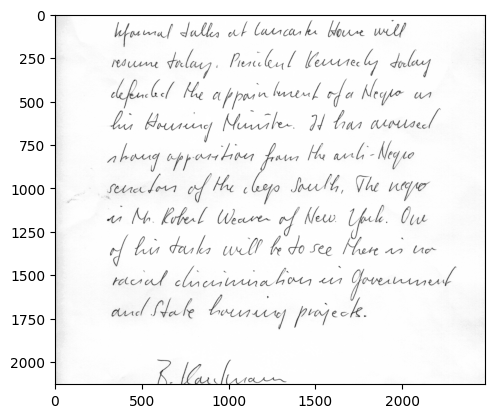

In [5]:
img = Image.open("handwritten-a01-043.png")
pixels = np.array(img)
horizontal_projection = np.sum(255 - pixels, axis=1)
#plt.plot(horizontal_projection)
plt.imshow(img, cmap='gray')
plt.show()

### Find local minima

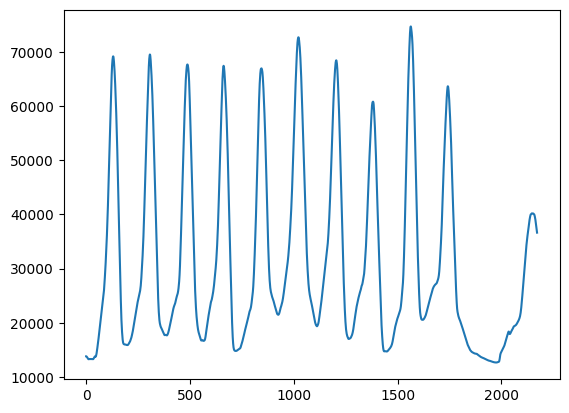

In [6]:
# code from https://www.kaggle.com/code/irinaabdullaeva/text-segmentation

def smooth(x, window_len=70, window='hanning'):
#     if x.ndim != 1:
#         raise ValueError("smooth only accepts 1 dimension arrays.") 
    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.") 
    if window_len<3:
        return x
    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")
    s = np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w = np.ones(window_len,'d')
    else:
        w = eval('np.'+window+'(window_len)')

    y = np.convolve(w/w.sum(),s,mode='valid')
    return y

smoothed = smooth(horizontal_projection, 45, window='flat')
plt.plot(smoothed)

local_minima = argrelextrema(smoothed, np.less)
local_minima = np.array(local_minima).flatten()

### Cropping lines

[(45, 186), (198, 379), (389, 555), (566, 720), (720, 925), (925, 1112), (1112, 1265), (1265, 1436), (1448, 1619), (1622, 1972), (2041, 2150)]


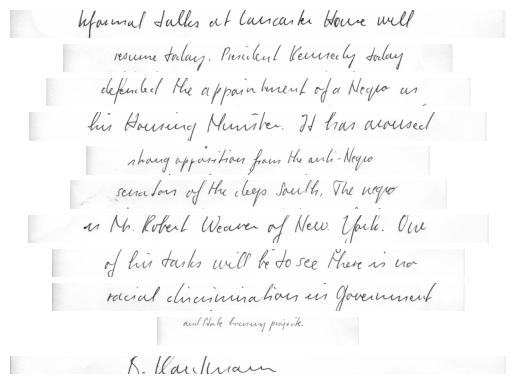

In [7]:
def crop_lines(local_minima, threshold=0):
    x1 = 0
    cropped = []
    diff = []
    for i, min in enumerate(local_minima):
        x2 = min
        #print(f"x1 = {x1}, x2 = {x2}, diff = {x2-x1}")
        if x2-x1 >= threshold:
            cropped.append((x1, x2))
        x1 = min
    return cropped

def show_cropped_lines(img, cropped):
    plots = len(cropped)
    for i, l in enumerate(cropped):
        line = img[l[0]:l[1]]
        plt.subplot(plots, 1, i+1)
        plt.axis('off')
        _ = plt.imshow(line, cmap='gray')
        plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis

cropped = crop_lines(local_minima, 100)
cropped = [(int(x1), int(x2)) for x1, x2 in cropped]
print(cropped)
show_cropped_lines(pixels, cropped)

### Text encoding/decoding

In [21]:
chars = ['\n', ' ', '!', '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '¿', '’', '“', '”', '„', '<PAD>']

def encode(text: str):
    encoded_text = []
    for char in text:
        encoded_text.append(chars.index(char))
    return encoded_text

def decode(char_ids: list):
    decoded_text = ''
    for id in char_ids:
        if id != 81: # char_id 81 corresponds to the padding token
            decoded_text += chars[id]
    return decoded_text

def pad_ids(char_ids: list, length: int):
    list_len = len(char_ids)
    if list_len < length:
        char_ids += [80] * (length - list_len)
    return char_ids

### Preparing the Dataset

In [8]:
df = pd.read_csv("segments.csv", delimiter="\t")


In [9]:
#define nn datastructure
class OCR_dataset(Dataset):
    def __init__(self, df: pd.DataFrame, root_path: str):
        self.df = df
        self.root_path = root_path

    def __len__(self):
        return len(df)

    def __getitem__(self, idx):
        path = self.root_path + self.df.iloc[idx]['file_path']
        start = self.df.iloc[idx]['segment_start']
        end = self.df.iloc[idx]['segment_end']
        text = self.df.iloc[idx]['segment_text']

        target = encode(text)
        target = pad_ids(target, max_text_length) # should actually by size of charset
        target = torch.LongTensor(target)

        image = Image.open(path)
        width, _ = image.size
        image = image.crop((0, start, width, end))
        image = image.resize((img_width, img_height))
        image = TF.to_tensor(image)
        return image, target

In [10]:
root_path = "iam-handwritten-forms-dataset/versions/1/data"
#root_path = "/home/jan/.cache/kagglehub/datasets/naderabdelghany/iam-handwritten-forms-dataset/versions/1/data"
data = OCR_dataset(df, root_path)
generator = torch.Generator().manual_seed(299792458) # Generator for reproducability
train_data, eval_data, test_data = random_split(data, [.8, .1, .1], generator)

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=4,
    shuffle=True,
    num_workers=0
)
test_dataloader = DataLoader(
    dataset=eval_data,
    batch_size=4,
    shuffle=True,
    num_workers=0
)
eval_dataloader = DataLoader(
    dataset=test_data,
    batch_size=4,
    shuffle=True,
    num_workers=0
)

### The Model

In [22]:
#define nn layers
class OCR_neural_network(nn.Module):
    def __init__(self, img_width, img_height, char_set_size):
        super().__init__()
        self.rnn_height = img_height//4
        self.rnn_width = img_width//4
        self.rnn_feature_number = self.rnn_height * 64
        
        self.conv_pooling_stack = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.after_resize_stack = nn.Sequential(
            nn.Linear(self.rnn_feature_number, 64),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
            
        self.rnn1 = nn.LSTM(64, 128, batch_first = True, bidirectional = True, dropout = 0.25)
        self.rnn2 = nn.LSTM(256, 64, batch_first = True, bidirectional = True, dropout = 0.25)

        self.output_layer = nn.Linear(128, char_set_size)
        
    def forward(self, x):
        batch_size, seq_len, channels, height = x.size()
           
        x = self.conv_pooling_stack(x)
    
        #reshape for rnn
        x = x.permute(0, 3, 1, 2)
        x = torch.reshape(x, (batch_size, self.rnn_width, self.rnn_feature_number))    
            
        x = self.after_resize_stack(x)
    
        x, y = self.rnn1(x) #y is not used
        x, y = self.rnn2(x)
    
        x = self.output_layer(x)
        return x



In [23]:
#create instance of model
model = OCR_neural_network(img_width, img_height, char_set_size)

total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

#criterion = nn.CTCLoss(reduction="mean", zero_infinity=true)
criterion = nn.CrossEntropyLoss(reduction="mean")
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

Total number of parameters: 523,921


In [24]:
#train NN
for epoch in range(num_epochs):
    print("epoch" + str(epoch))
    model.train()
    print("model in training mode")
    loss_list = []

    for image_data, label in train_dataloader:
        #print(label.shape)
        optimizer.zero_grad()
        outputs = model(image_data)
        #print(outputs.shape)
        outputs = outputs.permute(0, 2, 1)
        #print(outputs.shape)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()

        #loss monitoring
        loss_list.append(loss.item())
        print(loss.item())

    plt.plot(loss_list)

#test NN
#for 

    

epoch0
model in training mode
torch.Size([4, 384])
torch.Size([4, 384, 81])
torch.Size([4, 81, 384])
4.449112415313721
torch.Size([4, 384])
torch.Size([4, 384, 81])
torch.Size([4, 81, 384])
4.35521936416626
torch.Size([4, 384])
torch.Size([4, 384, 81])
torch.Size([4, 81, 384])
4.229851722717285
torch.Size([4, 384])
torch.Size([4, 384, 81])
torch.Size([4, 81, 384])
4.030259132385254
torch.Size([4, 384])
torch.Size([4, 384, 81])
torch.Size([4, 81, 384])
3.732970952987671
torch.Size([4, 384])
torch.Size([4, 384, 81])
torch.Size([4, 81, 384])
3.2942209243774414
torch.Size([4, 384])
torch.Size([4, 384, 81])
torch.Size([4, 81, 384])


KeyboardInterrupt: 

In [9]:
print("hello")

hello


## LLM 


In [31]:
from transformers import AutoModelForCausalLM, AutoTokenizer

llm_model_name = "Qwen/Qwen3-1.7B"

# load the tokenizer and the model
tokenizer = AutoTokenizer.from_pretrained(llm_model_name)
model = AutoModelForCausalLM.from_pretrained(
    llm_model_name,
    torch_dtype="auto",
    device_map=None
)



C:\Users\ASUS\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
`torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00, 10.67it/s]


In [48]:
input_text = "Note circalation soared for the sixth successive week - "\
"thir time by more than 15,000,000 last weet. "\
"And that brought the fiyure to a record 2,415,000,000." \
"This was 100,000,000 more than the corresponding week last year and 37,000,000 up on"\
"the 1960 record set last Christmus."\
"Now look at the other side of all"\
"these coins."


# prepare the model input
prompt = "You are a text corrector. Only correct spelling and punctuation. Do not edit content. Do not rephrase. Only output the corrected text." \
            f"Input text: {input_text}"
messages = [
    {"role": "user", "content": prompt}
]
text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True,
    enable_thinking=False # Switches between thinking and non-thinking modes. Default is True.
)
model_inputs = tokenizer([text], return_tensors="pt").to(model.device)

# conduct text completion
generated_ids = model.generate(
    **model_inputs,
    max_new_tokens=32768
)
output_ids = generated_ids[0][len(model_inputs.input_ids[0]):].tolist() 



llm_output = tokenizer.decode(output_ids, skip_special_tokens=True).strip("\n")

print("input:\n", input_text)
print("output:\n", llm_output)




input:
 Note circalation soared for the sixth successive week - thir time by more than 15,000,000 last weet. And that brought the fiyure to a record 2,415,000,000.This was 100,000,000 more than the corresponding week last year and 37,000,000 up onthe 1960 record set last Christmus.Now look at the other side of allthese coins.
output:
 Note circulation soared for the sixth successive week - third time by more than 15,000,000 last week. And that brought the figure to a record 2,415,000,000. This was 100,000,000 more than the corresponding week last year and 37,000,000 up on the 1960 record set last Christmas. Now look at the other side of all these coins.


In [49]:
import Levenshtein

def combine_into_a_line(lines: object):
    line = ""
    for l in lines:
        line += f"{l} "
    if line[-1] == " ":         #remove the space added at the end of the line
        line = line[:-1]
    return line



def accuracy(label: list[str], llm_output: list[str]):
    accuracy = Levenshtein.ratio(label, llm_output)
    print("Accuracy =", accuracy)


In [50]:
text = df[df["text_number"] == "a06-119"]
lines = text["segment_text"]

label = combine_into_a_line(lines)
accuracy(label, llm_output)

print(label)
print(llm_output)

Accuracy = 0.9953632148377125
Note circulation soared for the sixth successive week - this time by more than 15,000,000 last week. And that brought the figure to a record 2,415,000,000. This was 100,000,000 more than the corresponding week last year and 37,000,000 up on the 1960 record set last Christmas. Now look at the other side of all these coins.
Note circulation soared for the sixth successive week - third time by more than 15,000,000 last week. And that brought the figure to a record 2,415,000,000. This was 100,000,000 more than the corresponding week last year and 37,000,000 up on the 1960 record set last Christmas. Now look at the other side of all these coins.
